# Example: Classification

In [1]:
import matplotlib.pyplot as plt
from torch.nn.utils import parameters_to_vector
from torch.optim import Adam

from preds.models import MLPS
from preds.likelihoods import CategoricalLh
from preds.datasets import TwoMoons
from preds.laplace import Laplace
from preds.utils import setup_grid

/home/mereur1/miniconda3/envs/envBNN/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Hyperparameters

In [2]:
width = 25
depth = 3
prior_prec = 1
lr = 5e-3
n_epochs = 250
n_samples = 5000
lh = CategoricalLh()

#### Two moons dataset

In [3]:
device = 'cpu'
ds = TwoMoons(random_seed=711, double=False)
X_train, y_train = ds.data.to(device), ds.targets.to(device).long()
train_loader = [(X_train, y_train)]  # mock

#### Grid for plotting predictive

In [4]:
grid, xx, yy = setup_grid(ds.data.numpy(), h=0.05, buffer=1)
grid = grid.to(device).float()
X = ds.data.numpy()
y = ds.targets.numpy()

clevels = 30  # color levels in contour
ms = 50  # marker size

def plot_contour(pred_Z, ax=plt, vmin=0, vmax=1, cmap='RdBu'):
    Z = pred_Z.reshape(xx.shape)
    contour = ax.contourf(xx, yy, Z, alpha=0.7, cmap=cmap, levels=clevels, antialiased=True, vmin=vmin, vmax=vmax)
    ax.scatter(X[y==0, 0], X[y==0, 1], color='tab:blue', s=ms, lw=1, edgecolors='black', marker='o')
    ax.scatter(X[y==1, 0], X[y==1, 1], color='tab:red', s=ms, lw=1, edgecolors='black', marker='o')
    ax.set_xticks([])
    ax.set_yticks([])
    return contour

## Neural network training (MAP estimation)

In [5]:
model = MLPS(2, [width]*depth, 2, activation='tanh').to(device)
optim = Adam(model.parameters(), lr=lr)
losses = list()
for i in range(n_epochs):
    f = model(X_train)
    w = parameters_to_vector(model.parameters())
    reg = 0.5 * prior_prec * w @ w
    loss = - lh.log_likelihood(y_train, f) + reg
    loss.backward()
    optim.step()
    losses.append(loss.item())
    model.zero_grad()


# AAAA

In [6]:

lap = Laplace(model, float(prior_prec), lh)
model_type='glm' 
cov_type='full'
lap.infer(train_loader, cov_type=cov_type, dampen_kron=model_type=='bnn')
preds = lap.predictive_samples_glm(grid, n_samples=1)
print(preds.shape)
preds = preds.mean(axis=0)[:, 0]
print(preds.shape)

torch.Size([1, 10647, 2])
torch.Size([10647])


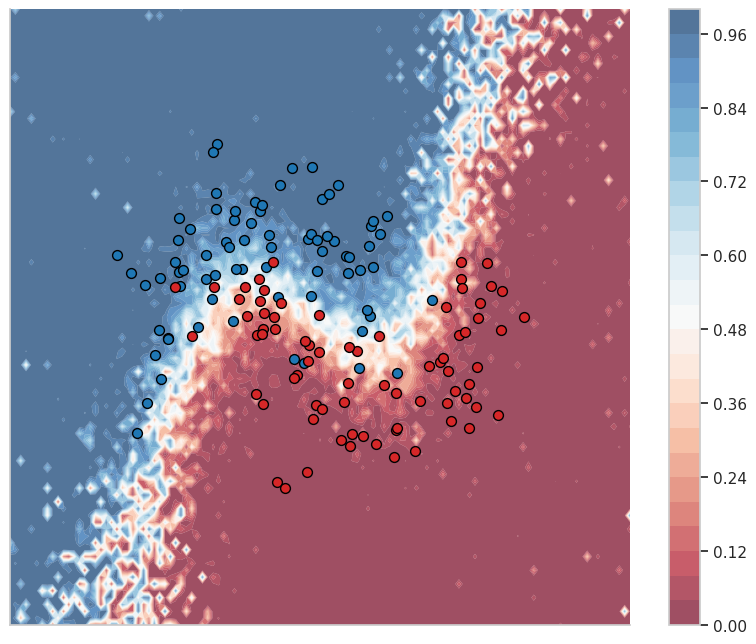

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(10, 8))

Z = preds.reshape(xx.shape)
contour = ax.contourf(xx, yy, Z, alpha=0.7, cmap='RdBu', levels=30, antialiased=True, vmin=0, vmax=1)
fig.colorbar(contour)
ax.scatter(X[y==0, 0], X[y==0, 1], color='tab:blue', s=ms, lw=1, edgecolors='black', marker='o')
ax.scatter(X[y==1, 0], X[y==1, 1], color='tab:red', s=ms, lw=1, edgecolors='black', marker='o')
ax.set_xticks([])
ax.set_yticks([])
#pred = get_pred_for('glm', 'full')
#plot_contour(preds, ax=ax)
plt.show()

## Infer Laplace-_GGN_ and predict

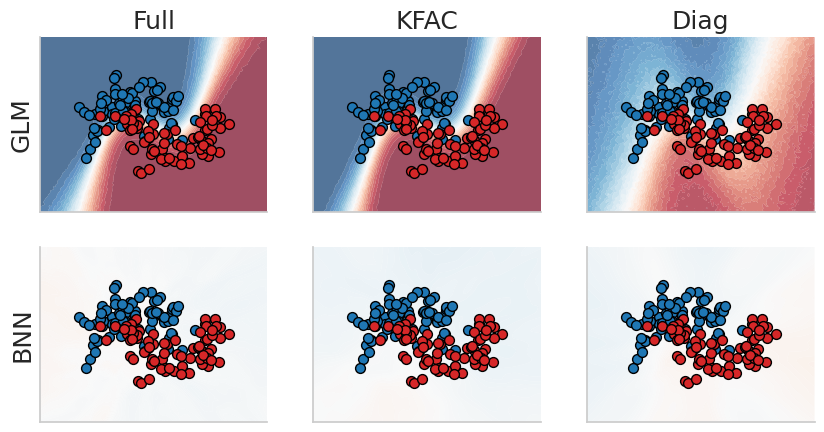

In [8]:
lap = Laplace(model, float(prior_prec), lh)


def get_pred_for(model_type='glm', cov_type='full'):
    lap.infer(train_loader, cov_type=cov_type, dampen_kron=model_type=='bnn')
    if model_type == 'glm':
        return lap.predictive_samples_glm(grid, n_samples=1000).mean(axis=0)[:, 0]
    elif model_type == 'bnn':
        return lap.predictive_samples_bnn(grid, n_samples=1000).mean(axis=0)[:, 0]
    else:
        raise ValueError('unsupported model_type.')


# Plot predictions of GLM and BNN in grid
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10, 5))

axs[0, 0].set_title('Full', fontsize=18)
axs[0, 1].set_title('KFAC', fontsize=18)
axs[0, 2].set_title('Diag', fontsize=18)
axs[0, 0].set_ylabel('GLM', fontsize=18)
axs[1, 0].set_ylabel('BNN', fontsize=18)

# GLM
pred = get_pred_for('glm', 'full')
plot_contour(pred, ax=axs[0, 0])
pred = get_pred_for('glm', 'kron')
plot_contour(pred, ax=axs[0, 1])
pred = get_pred_for('glm', 'diag')
plot_contour(pred, ax=axs[0, 2])

# NN
pred = get_pred_for('bnn', 'full')
plot_contour(pred, ax=axs[1, 0])
pred = get_pred_for('bnn', 'kron')
plot_contour(pred, ax=axs[1, 1])
pred = get_pred_for('bnn', 'diag')
plot_contour(pred, ax=axs[1, 2])

plt.show()

## Aleatoric and epistemic variance decomposition (GLM-full)

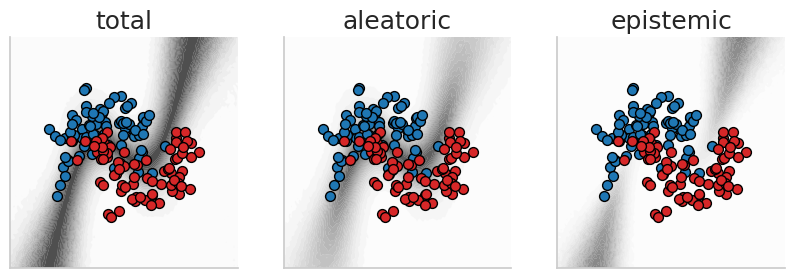

In [9]:
lap.infer(train_loader, cov_type='full', dampen_kron=False)
pred_samples = lap.predictive_samples_glm(grid, n_samples=1000)
pred_mean = pred_samples.mean(dim=0)[:, 0]
    
var_aleatoric = (pred_samples - pred_samples**2).mean(dim=0)[:, 0]
var_epistemic = pred_samples.var(dim=0, unbiased=False)[:, 0]
var_total = var_aleatoric + var_epistemic


fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(10, 3))

axs[0].set_title('total', fontsize=18)
axs[1].set_title('aleatoric', fontsize=18)
axs[2].set_title('epistemic', fontsize=18)

plot_contour(var_total, ax=axs[0], vmax=0.25, cmap='gray_r')
plot_contour(var_aleatoric, ax=axs[1], vmax=0.25, cmap='gray_r')
plot_contour(var_epistemic, ax=axs[2], vmax=0.25, cmap='gray_r')

plt.show()

In [10]:
preds = get_pred_for('glm', 'full')

In [11]:
preds

tensor([0.9500, 0.9500, 0.9475,  ..., 0.0501, 0.0363, 0.0329])

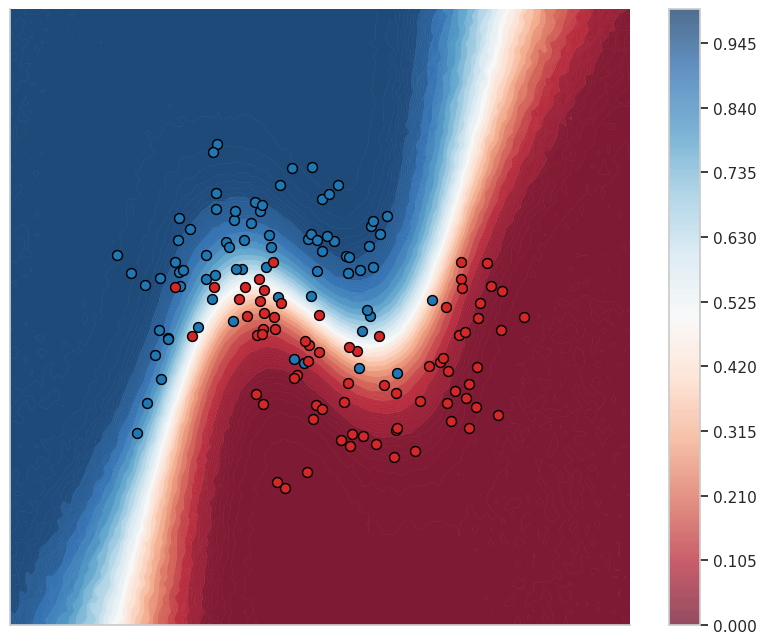

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(10, 8))

Z = preds.reshape(xx.shape)
contour = ax.contourf(xx, yy, Z, alpha=0.7, cmap='RdBu', levels=200, antialiased=True, vmin=0, vmax=1)
fig.colorbar(contour)
ax.scatter(X[y==0, 0], X[y==0, 1], color='tab:blue', s=ms, lw=1, edgecolors='black', marker='o')
ax.scatter(X[y==1, 0], X[y==1, 1], color='tab:red', s=ms, lw=1, edgecolors='black', marker='o')
ax.set_xticks([])
ax.set_yticks([])
pred = get_pred_for('glm', 'full')
plot_contour(pred, ax=ax)
plt.show()

In [13]:
preds.max(), preds.min()

(tensor(0.9996), tensor(0.0006))